## Homework 4: due 2022/05/09 23:59 (100%)

### - Tutorial : 

1. Training on MNIST: https://www.kaggle.com/code/juiyangchang/cnn-with-pytorch-0-995-accuracy
2. Torchvision transforms: https://pytorch.org/vision/stable/transforms.html
3. Pytorch learning rate scheduler: https://pytorch.org/docs/stable/optim.html
4. How to get learning rate: https://stackoverflow.com/questions/52660985/pytorch-how-to-get-learning-rate-during-training

### - After you go through the tutorials, you should be able to work on this assignment.

### - Please answer the following questions and work directly on this jupyter notebook.

### - Make sure the code can be run and show the result and figures properly.

### - Please write down your observation with markdown in this notebook briefly.



#### You will train a multi-class classfication model in this part. The data contains the images with three categories: cats, dogs and pandas. You can find the details of each column at https://www.kaggle.com/datasets/ashishsaxena2209/animal-image-datasetdog-cat-and-panda.

In [1]:
# Import necessory modules
%matplotlib inline
import os
import glob
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.models as models
from torch.optim.lr_scheduler import MultiStepLR
import PIL.Image as Image
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
import math
import warnings
warnings.filterwarnings('ignore')

In [2]:
# For reproduce the result
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

### 1. Define the model and dataset (30%)

#### 1.1 Please create a class **AnimalDataset** for loading the data, and a varibale ***transform*** for the preprocessing transformation should be created for later usage.  (15%)

In [3]:
class AnimalDataset(Dataset):
    def read_data_set(self):

        all_img_files = []
        all_labels = []

        class_names = os.walk(self.data_set_path).__next__()[1]

        for index, class_name in enumerate(class_names):
            label = index
            img_dir = os.path.join(self.data_set_path, class_name)
            img_files = os.walk(img_dir).__next__()[2]

            for img_file in img_files:
                img_file = os.path.join(img_dir, img_file)
                img = Image.open(img_file)
                if img is not None:
                    all_img_files.append(img_file)
                    all_labels.append(label)

        return all_img_files, all_labels, len(all_img_files), len(class_names)

    def __init__(self, data_set_path, transforms=None):
        self.data_set_path = data_set_path
        self.image_files_path, self.labels, self.length, self.num_classes = self.read_data_set()
        self.transforms = transforms

    def __getitem__(self, index):
        image = Image.open(self.image_files_path[index])
        image = image.convert("RGB")

        if self.transforms is not None:
            image = self.transforms(image)

        return {'image': image, 'label': self.labels[index]}

    def __len__(self):
        return self.length
        

#### 1.2 Please create a class **CNN** as your network with the architecture below. (15%)
##### (Note. Please determine the output layer by the task)

| Block 1 | Block 2 |  Fully Connected Layer |
|:---:|:---:|:---:|
| 3x3 conv, 64 | 3x3 conv, 128 |  Linear, 512 |
| ReLU         | ReLU   |Dropout(p=0.5)  |
| 2x2 MaxPooling, downsampling factor 2       | 2x2 MaxPooling, downsampling factor 2   | ReLU  |
|          |    |Linear, 256  |
|          |    |Dropout(p=0.5)  |
|          |    |ReLU |

In [4]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
          
        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(3200, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(256, num_classes)
        )
          
        for m in self.features.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
        for m in self.classifier.children():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x 
               

### 2. Train the model (70%)

#### 2.1 Please load the train/validation/test data from ***./animals*** respectively and resize the image to 32x32. For the data preprocessing, please apply ***RandomHorizontalFlip(p=0.5)*** and ***RandomRotation((-10,10))*** as data augmentations. Also, scale all the value in the range between 0 and 1 and normalize with mean value ***(0.485,0.456,0.406)*** and standard deviation ***(0.229,0.224,0.225)*** for RGB channel respectively. At last, create the DataLoaders with batch size 32.(10%)
##### (Note. The mean and standard deviation is calculated from ImageNet dataset) 

In [5]:
HorizontalFlip = transforms.RandomHorizontalFlip(p=0.5)
Rotation = transforms.RandomRotation((-10,10))
transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))

epoch = 100
batch = 32
learning_rate = 0.005
beta1 = 0.9
beta2 = 0.99

transforms_train = transforms.Compose([transforms.Resize((32, 32)),
                                       HorizontalFlip,Rotation,
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))])

transforms_test = transforms.Compose([transforms.Resize((32, 32)),
                                       HorizontalFlip,Rotation,
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))])

transforms_val = transforms.Compose([transforms.Resize((32, 32)),
                                       HorizontalFlip,Rotation,
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))])

train = AnimalDataset(data_set_path="animals/train", transforms=transforms_train)
train_loader = DataLoader(train, batch_size=batch, shuffle=True)

test = AnimalDataset(data_set_path="animals/test", transforms=transforms_test)
test_loader = DataLoader(test, batch_size=batch, shuffle=True)

val = AnimalDataset(data_set_path="animals/val", transforms=transforms_val)
val_loader = DataLoader(val, batch_size=batch, shuffle=True)

#### 2.2 Train the CNN model with the same hyperpameters below and do the validation every epoch. Choose the appropriate type of loss according to the task. Please record the learning rate, training/validation loss and training/validation accuracy every epoch. Also, save the model weights as ***model_without_scheduler.pth***(20%)


| | Learning rate | epochs | optimizer | weight decay | $\beta _1$|$\beta _2$|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|***Hyperparameter***| 5e-3 | 100 | Adam | 1e-2 | 0.9 | 0.99 |

In [6]:
def accuracy(predictions, labels):
    classes = torch.argmax(predictions, dim=1)
    return torch.mean((classes == labels).float())

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

num_classes_train = train.num_classes
custom_model_train = CNN(num_classes=num_classes_train).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_train = torch.optim.Adam(custom_model_train.parameters(), lr=learning_rate, weight_decay = 0.01 ,betas = (beta1,beta2))

a=[]
b=[]
c=[]
d=[]


for e in tqdm(range(100)):
    training_loss = 0
    val_loss = 0
    training_correct = 0
    val_correct = 0
    for i, item in enumerate(train_loader):
        images_train = item['image'].to(device)
        labels_train = item['label'].to(device)

        # Forward pass
        outputs_train = custom_model_train(images_train)
        loss_train = criterion(outputs_train, labels_train)

        # Backward and optimize
        optimizer_train.zero_grad()
        loss_train.backward()
        optimizer_train.step()
        
        training_loss+=loss_train.detach().numpy()
        training_correct += accuracy(outputs_train, labels_train).detach().numpy()
        
    a.append(training_loss/len(train_loader))
    c.append(training_correct/len(train_loader))

    #custom_model_val.eval()
    for i, item in enumerate(val_loader):
        with torch.no_grad():
            images_val = item['image'].to(device)
            labels_val = item['label'].to(device) 
 
            outputs_val = custom_model_train(images_val)
            loss_val = criterion(outputs_val, labels_val)

            val_loss += loss_val.detach().numpy()
            val_correct += accuracy(outputs_val, labels_val).detach().numpy()
            
    b.append(val_loss/len(val_loader))
    d.append(val_correct/len(val_loader))
    
torch.save(custom_model_train, 'model_without_scheduler.pth')

  0%|          | 0/100 [00:00<?, ?it/s]

#### 2.3 Please draw the plot the learning rate, training/validation loss and training/validation accuracy and write down the observation. (10%)
##### (Example figure)
![image.png](https://github.com/tingyan08/Deep-Learning-and-Computer-Vision/blob/main/HW4/img/curve1.png?raw=true)

<function matplotlib.pyplot.show(close=None, block=None)>

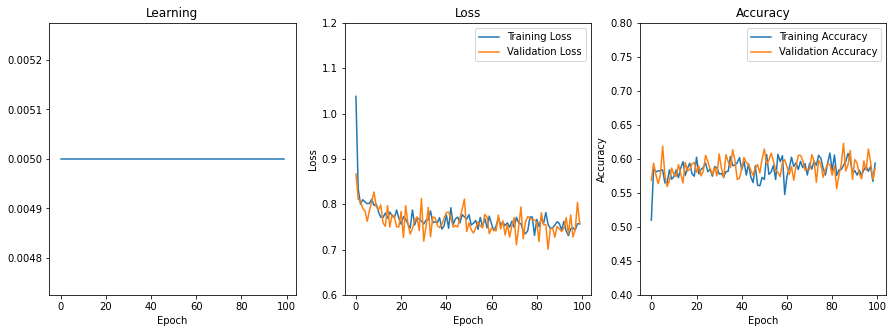

In [7]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
fig, (ax1,ax2,ax3) = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(15)

plt.subplot(1,3,1)
plt.title('Learning')
plt.xlabel('Epoch')

x = list(range(100))
y = []
for v in range(100):
    optimizer_train.step()
    y.append(get_lr(optimizer_train))
plt.plot(x, y)

plt.subplot(1,3,2)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.6,1.2)
plt.plot(range(len(a)),a,label='Training Loss')
plt.plot(range(len(b)),b,label='Validation Loss')
plt.legend()

plt.subplot(1,3,3)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.4,0.8)
plt.plot(range(len(c)),c,label='Training Accuracy')
plt.plot(range(len(d)),d,label='Validation Accuracy')
plt.legend()
plt.show

#### 2.4 Please retrain model with learning rate decay with decreasing factor 0.1 at 20 epoch and 60 epoch. The other parameters are as same as last question. Also, redraw the learning rate, accuracy and loss curves and save the weights as ***model_with_scheduler.pth***. (10%)
##### (Example figure)
![image.png](https://github.com/tingyan08/Deep-Learning-and-Computer-Vision/blob/main/HW4/img/curve2.png?raw=true)

In [8]:

scheduler = MultiStepLR(optimizer_train, [20, 60], 0.1)

a=[]
b=[]
c=[]
d=[]

for e in tqdm(range(epoch)):
    training_loss = 0
    val_loss = 0
    training_correct = 0
    val_correct = 0
    for i, item in enumerate(train_loader):
        images_train = item['image'].to(device)
        labels_train = item['label'].to(device)

        # Forward pass
        outputs_train = custom_model_train(images_train)
        loss_train = criterion(outputs_train, labels_train)

        # Backward and optimize
        optimizer_train.zero_grad()
        loss_train.backward()
        optimizer_train.step()
        
        training_loss+=loss_train.detach().numpy()
        training_correct += accuracy(outputs_train, labels_train).detach().numpy()
    
    scheduler.step()        
    a.append(training_loss/len(train_loader))
    c.append(training_correct/len(train_loader))
        
    #custom_model_val.eval()
    for i, item in enumerate(val_loader):
        with torch.no_grad():
            images_val = item['image'].to(device)
            labels_val = item['label'].to(device) 
 
            outputs_val = custom_model_train(images_val)
            loss_val = criterion(outputs_val, labels_val)

            val_loss += loss_val.detach().numpy()
            val_correct += accuracy(outputs_val, labels_val).detach().numpy()
            
    b.append(val_loss/len(val_loader))
    d.append(val_correct/len(val_loader))

torch.save(custom_model_train, 'model_with_scheduler.pth')
    

  0%|          | 0/100 [00:00<?, ?it/s]

<function matplotlib.pyplot.show(close=None, block=None)>

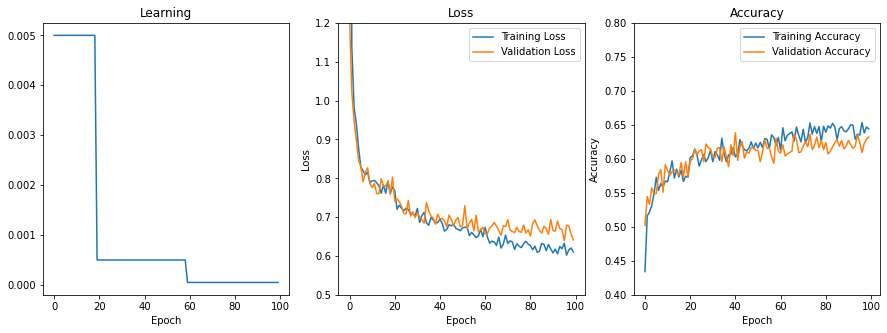

In [9]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(15)

plt.subplot(1,3,1)
plt.title('Learning')
plt.xlabel('Epoch')

optimizer_train = torch.optim.Adam(custom_model_train.parameters(), lr=learning_rate, weight_decay = 0.01 ,betas = (beta1,beta2))
scheduler = MultiStepLR(optimizer_train, [20, 60], 0.1)

x = list(range(100))
y = []
for v in range(100):
    scheduler.step()
    y.append(scheduler.get_last_lr()[0])

plt.plot(x, y)

plt.subplot(1,3,2)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.5,1.2)
plt.plot(range(len(a)),a,label='Training Loss')
plt.plot(range(len(b)),b,label='Validation Loss')
plt.legend()

plt.subplot(1,3,3)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.4,0.8)
plt.plot(range(len(c)),c,label='Training Accuracy')
plt.plot(range(len(d)),d,label='Validation Accuracy')
plt.legend()
plt.show

#### 2.5 Please calculate the confusion matrix and print the accuracy of two models with the test dataset. (10%)
##### (Example figure)
![image.png](https://github.com/tingyan08/Deep-Learning-and-Computer-Vision/blob/main/HW4/img/confusion%20matrix.png?raw=true)

In [10]:
for e in tqdm(range(epoch)):
    for i, item in enumerate(train_loader):
        images_train = item['image'].to(device)
        labels_train = item['label'].to(device)

        # Forward pass
        outputs_train = custom_model_train(images_train)
        loss_train = criterion(outputs_train, labels_train)

        # Backward and optimize
        optimizer_train.zero_grad()
        loss_train.backward()
        optimizer_train.step()

    confusion_matrix = torch.zeros(3, 3)
    with torch.no_grad():
        for i, item in enumerate(test_loader):
            images_test = item['image'].to(device)
            labels_test = item['label'].to(device)

            outputs = custom_model_train(images_test)
            _, preds = torch.max(outputs, 1)

            for t, p in zip(labels_test.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1

  0%|          | 0/100 [00:00<?, ?it/s]

Text(30.5, 0.5, 'Actuals')

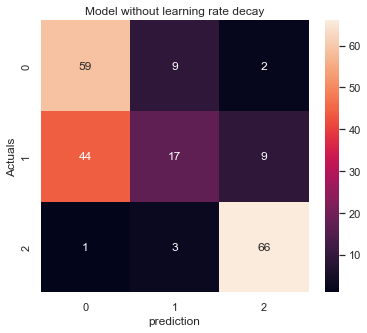

In [12]:
cm = confusion_matrix.numpy()           

sns.set()
fig, (ax1)=plt.subplots(1,1)
fig.set_figheight(5)
fig.set_figwidth(6)

sns.heatmap(cm,annot=True,ax=ax1)
ax1.set_title('Model without learning rate decay') 
ax1.set_xlabel('prediction') 
ax1.set_ylabel('Actuals') 


In [13]:
for e in tqdm(range(epoch)):
    for i, item in enumerate(train_loader):
        images_train = item['image'].to(device)
        labels_train = item['label'].to(device)

        # Forward pass
        outputs_train = custom_model_train(images_train)
        loss_train = criterion(outputs_train, labels_train)

        # Backward and optimize
        optimizer_train.zero_grad()
        loss_train.backward()
        optimizer_train.step()
    scheduler.step()        
    
    confusion_matrix2 = torch.zeros(3, 3)
    with torch.no_grad():
        for i, item in enumerate(test_loader):
            images_test = item['image'].to(device)
            labels_test = item['label'].to(device)

            outputs = custom_model_train(images_test)
            _, preds = torch.max(outputs, 1)

            for t, p in zip(labels_test.view(-1), preds.view(-1)):
                    confusion_matrix2[t.long(), p.long()] += 1
  

  0%|          | 0/100 [00:00<?, ?it/s]

Text(30.5, 0.5, 'Actuals')

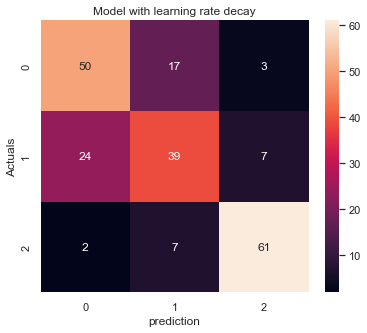

In [14]:
cm2 = confusion_matrix2.numpy() 

sns.set()
fig, (ax2)=plt.subplots(1,1)
fig.set_figheight(5)
fig.set_figwidth(6)

sns.heatmap(cm2,annot=True,ax=ax2)
ax2.set_title('Model with learning rate decay') 
ax2.set_xlabel('prediction') 
ax2.set_ylabel('Actuals') 

#### 2.6 Please choose the best model to predict the categories of images in the ***./animals/predict*** folder and show the figure with the prediction as title of each axes. (10%)
##### (Example figure)
![image.png](https://github.com/tingyan08/Deep-Learning-and-Computer-Vision/blob/main/HW4/img/img1.png?raw=true)

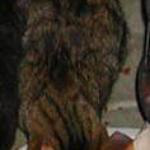

panda


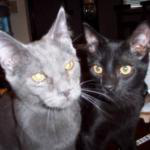

cats


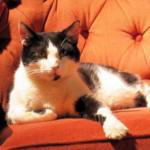

cats


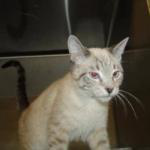

cats


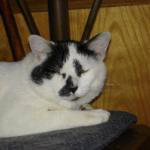

cats


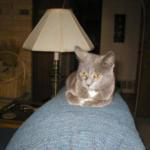

cats


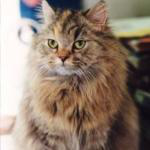

cats


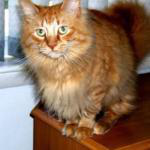

cats


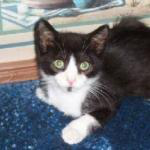

cats


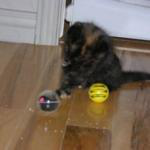

cats


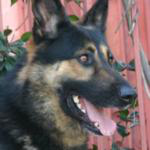

dogs


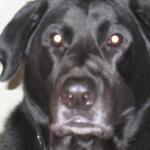

cats


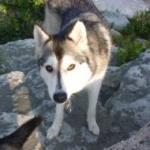

dogs


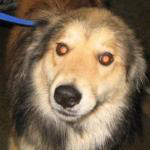

cats


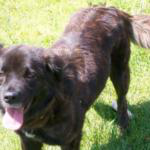

cats


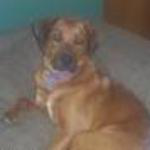

cats


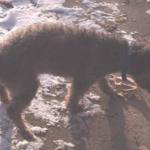

cats


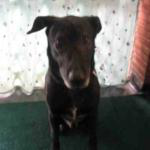

dogs


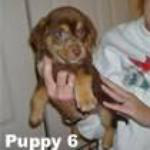

cats


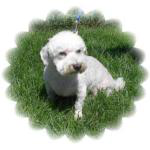

panda


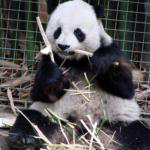

panda


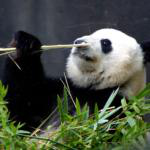

panda


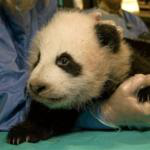

panda


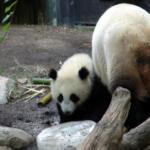

panda


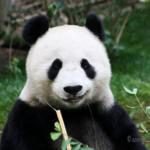

panda


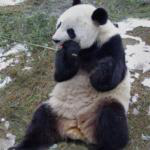

panda


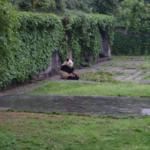

cats


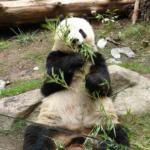

panda


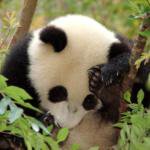

panda


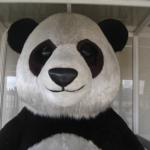

panda


In [15]:
import torch
from torch.autograd import Variable
from torchvision import transforms
import os
import shutil
from PIL import Image


def get_img(image_path):
    img_list = []
    for i in os.listdir(image_path):
        img_list.append(image_path+"/"+i)
    return img_list

def load_models():
    model = torch.load('model_with_scheduler.pth')
    model.eval()
    return model

def predict_image(image_path):
    image = Image.open(image_path)

    transformation = transforms_train

    image_tensor = transformation(image).float()
    image_tensor = image_tensor.unsqueeze_(0)

    if torch.cuda.is_available():
        image_tensor.cuda()

    model = load_models()

    input = Variable(image_tensor)
    output = model(input)
    index = output.data.cpu().numpy().argmax()

    display(image)
    return index


if __name__ == '__main__':
    image_path = 'animals\\prediction'
    img_list = get_img(image_path)
    for i in img_list:
        index = predict_image(i)
        animals_name = {0:'cats',1:'dogs',2:'panda'}
        print(animals_name[index])        
        target = 'animals\\prediction'+animals_name[index]
        if os.path.exists(target):
            shutil.copy(i, target)
        else:
            os.mkdir(target)
        shutil.copy(i, target)